In [ ]:
%cd ../

## Import packages

In [2]:
import sys
sys.path.append('./')

In [3]:
import torch
from pytorch_lightning import Trainer
from box import Box
import sys
import warnings

from src.models import Model
from src.data import TestDataModule

warnings.filterwarnings('ignore')

In [4]:
from torchvision.transforms import Resize
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from typing import List

## Model Inference

In [5]:
test_cfg = Box.from_yaml(open("configs/test_small.yaml", "r").read())
cfg = Box.from_yaml(open("configs/DeepColorTransferSmall.yaml", "r").read())
model_args = cfg.model_args
optimizer_args = cfg.optimizer_args
dataset_args = cfg.dataset_args
trainer_args = cfg.trainer_args

lgt_model = Model(
    l_bin=dataset_args.l_bin,
    ab_bin=dataset_args.ab_bin,
    num_classes=dataset_args.num_classes,
    **model_args,
    **optimizer_args,
)
lgt_model.model.load_state_dict(torch.load(test_cfg.model_path))
trainer = Trainer(accelerator=test_cfg.accelerator, devices=test_cfg.devices)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
# * Color transfer without semantic segmentation labels
lgt_model.model.use_seg = False
dm = TestDataModule(
    test_cfg.test_dir,
    dataset_args.l_bin,
    dataset_args.ab_bin,
    dataset_args.num_classes,
    False,
    test_cfg.resize_dim
)
out = trainer.predict(lgt_model, dm)

Predicting: 0it [00:00, ?it/s]

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


In [7]:
# Color transfer with semantic segmentation labels 
lgt_model.model.use_seg = True
dm.use_seg = True
seg_out = trainer.predict(lgt_model, dm)

Predicting: 0it [00:00, ?it/s]

## Visualization

In [8]:
def visualize_result(test_dir:Path, out:List["np.ndarray"], seg_out:List["np.ndarray"], resize_dim:int=None):
    
    in_img_dir = test_dir / "in_imgs"
    ref_img_dir = test_dir / "ref_imgs"
    in_img_paths = sorted(list(in_img_dir.glob("**/*.jpg")))
    ref_img_paths = sorted(list(ref_img_dir.glob("**/*.jpg")))

    num_cols = 4
    num_rows = len(out)
    col_map = {0:'Input',1:'Reference',2:'Without seg',3:'With seg'}

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,5*num_rows))
    list_axes = list(axes.flat)

    if resize_dim is not None:
        resize = Resize(resize_dim)

    for i in range(len(out)):
        in_img = Image.open(in_img_paths[i])
        ref_img = Image.open(ref_img_paths[i])
        if resize_dim is not None:
            in_img = resize(in_img)
            ref_img = resize(ref_img)
        list_axes[i*num_cols+0].imshow(in_img)
        list_axes[i*num_cols+1].imshow(ref_img)
        list_axes[i*num_cols+2].imshow(out[i])
        list_axes[i*num_cols+3].imshow(seg_out[i])
        if i == 0:
            for j in range(4):
                list_axes[j].set_title(col_map[j], fontsize=25) 

    for axi in axes.ravel():
        axi.set_axis_off()
    fig.tight_layout()
    _ = plt.show()

In [9]:
test_dir = Path(test_cfg.test_dir)

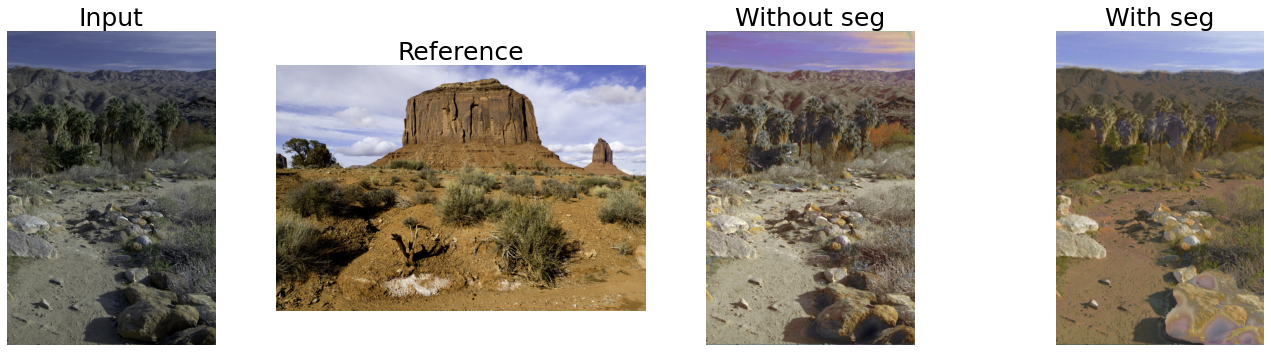

In [10]:
visualize_result(test_dir, out, seg_out)